## Purpose  
Take video recording and extract pictures of pages
 

In [6]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [5]:
cap = cv2.VideoCapture("media/wealth_of_nations_page_turning.mp4")
frames = []
while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)
    

In [7]:
np.shape(frames)

(338, 3840, 2160, 3)

338 is the count of frames, 3840 is the height, 2160 the width, and 3 is for the color.

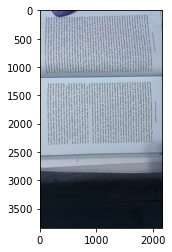

In [52]:
plt.imshow(frames[200])

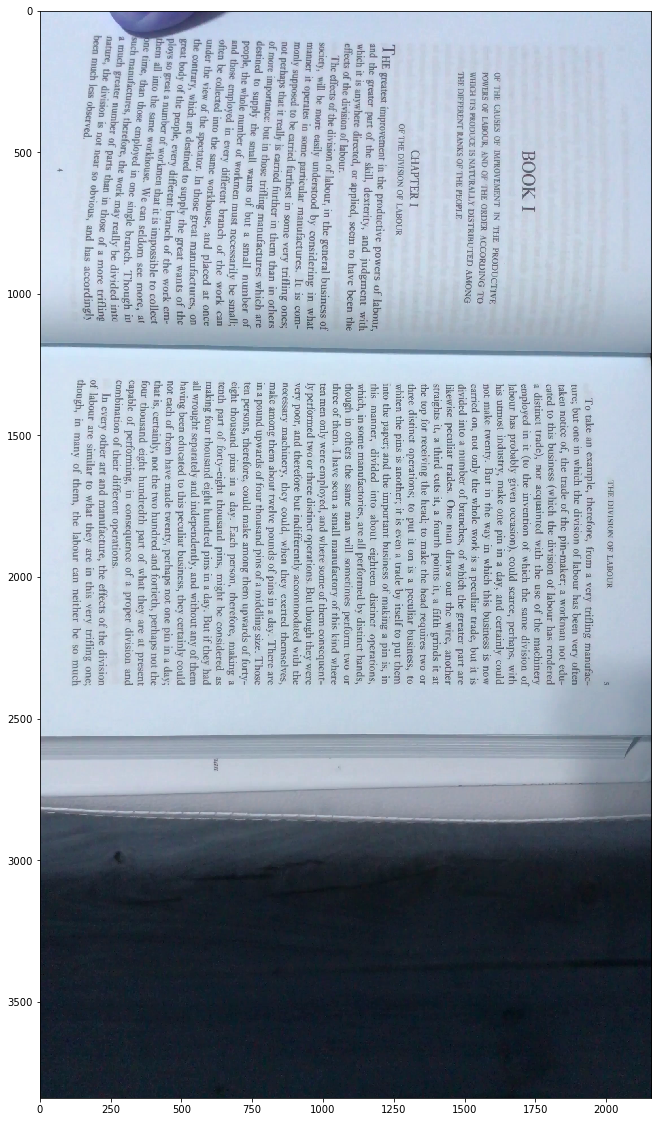

In [29]:
frame=frames[0]
fig=plt.figure(figsize = (20,20))
plt.imshow(frame, interpolation="nearest")

Lets rotate our images

In [33]:
def draw_frame(frame, figsize=(20,20)):
    #added for grayscale images below
    shape=np.shape(frame)
    fig=plt.figure(figsize = figsize)
    if len(shape)==2:
        plt.imshow(frame, cmap='gray', vmin=0, vmax=255, interpolation="nearest")
    else:
        plt.imshow(frame, interpolation="nearest")
    plt.show()

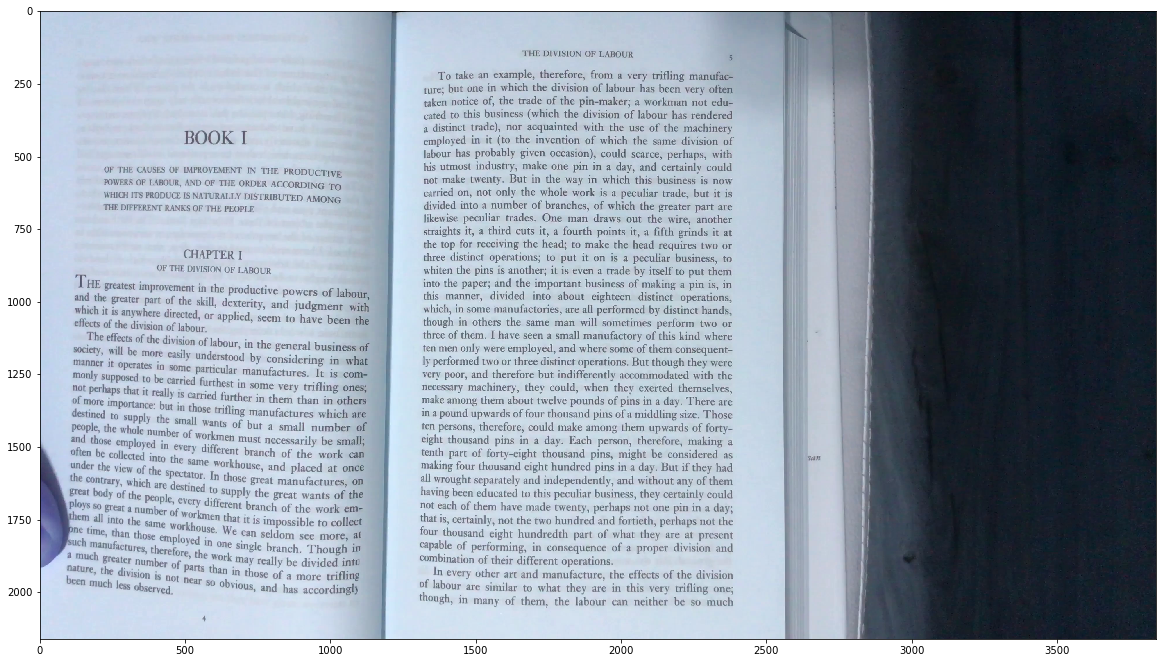

In [31]:
rotated_frame=cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
draw_frame(rotated_frame)

In [53]:
rotated_frames=[cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE) for frame in frames]

# Identify New Set of Pages
Now we have a challenge, how do we handle recognizing pages out of the video?   
  
First, think about what this algorithm needs to do. It should be good enough to identify unique pages. We don't  need it to be perfect because we can always de-duplicate pages after running OCR.  
  
There are a variety of methods to use. Since our camera should be static and the object, the book, is static I will first try a basic differencing approach between images.   
  
Before doing all that, let's simplify the problem further by converting to grayscale.

In [223]:
thresh

122.0

In [245]:
cv2.THRESH_BINARY | cv2.THRESH_OTSU

8

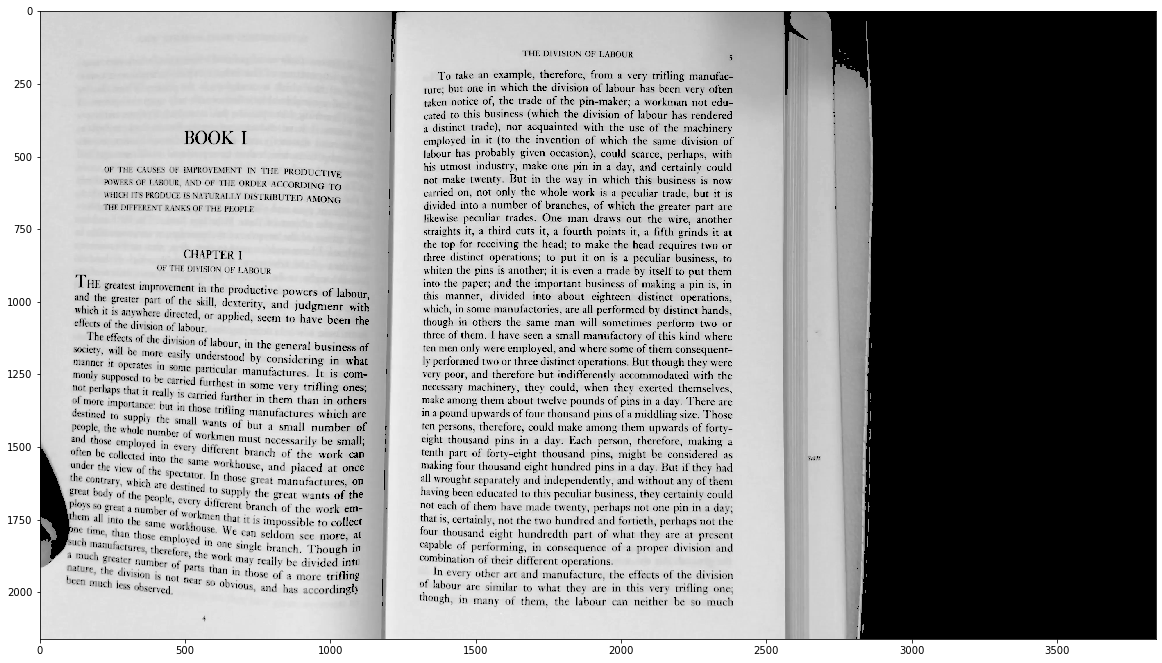

In [255]:
frame=rotated_frames[0]
gray =  cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
(thresh, bw) = cv2.threshold(gray, 127, 255, cv2.THRESH_TOZERO )
draw_frame(bw)

In [256]:
cleaned_frames=[cv2.threshold(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), 127, 255, cv2.THRESH_TOZERO)[1] for frame in rotated_frames]

In [257]:
#difference
i=10
A,B = cleaned_frames[i],cleaned_frames[i+1]
diff=B-A
diff

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

notice diff is still a matrix. Always keep in mind the shape of the data you are working with when working with images and videos. While we could create some form of model off of this matrix, it will be tough  because of the number of dimensions. Instead we can sum up the difference and see if that will be informative enough to detect the pages.

In [262]:
summed_diff=np.sum(diff)
summed_diff

-1528233

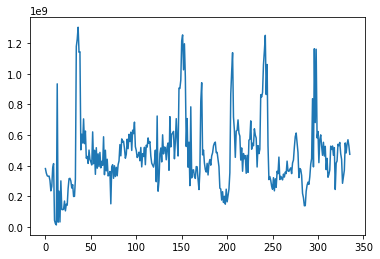

In [263]:
#summed diff is 0, potentially great! Lets plot the summed difference for all frames
summed_diffs=[]
for A,B in zip(cleaned_frames, cleaned_frames[1:-1]):
    summed_diffs.append(np.sum(A-B))
plt.plot(summed_diffs)

Uh oh, diff should be negative sumtimes! The issue here is a bit tricker to beginner coders. 
Numpy uses data more efficiently than python. Notice how the dtype is listed as uint8. 
A uint8 is short for unisgned 8 bit integer. That means it can represent values from 0 to 2^8 (binary=2)


In [264]:
A=cleaned_frames[0]
B=cleaned_frames[200]
diff=(A.astype(np.int16)-B.astype(np.int16))
diff

array([[31, 31, 31, ...,  0,  0,  0],
       [31, 31, 31, ...,  0,  0,  0],
       [31, 31, 31, ...,  0,  0,  0],
       ...,
       [22, 22, 22, ...,  0,  0,  0],
       [22, 22, 22, ...,  0,  0,  0],
       [22, 22, 22, ...,  0,  0,  0]], dtype=int16)

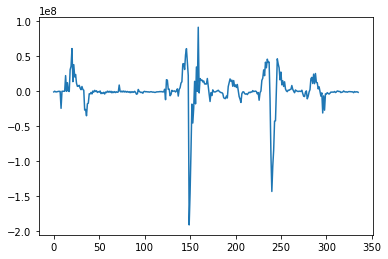

In [265]:
#summed diff is 0, potentially great! Lets plot the summed difference for all frames
summed_diffs=[]
for A,B in zip(cleaned_frames, cleaned_frames[1:-1]):#remove that last frame because it is too large of a value
    diff=np.sum(A.astype(np.int16)-B.astype(np.int16))
    summed_diffs.append(diff)
plt.plot(summed_diffs)

Woah, what should we do with that? Well first lets figure out how many pages are in the video. I went back and counted, there are 3

From looking at this data I see 4 page turns that appear to be very negative differences. We could do a simple threshold at -2e7, that 4th caught frame probably won't matter but cost us an extra OCR call. See the below line

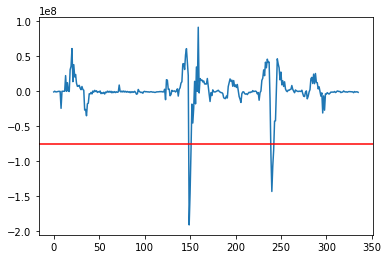

In [268]:
proposed_threshold=-0.75e8
plt.plot(summed_diffs)

plt.axhline(y=proposed_threshold, color='r', linestyle='-')

The algorithm would be: find each crossover point with window ~30 frames. Then find a stable point (little change) between successive frames

# Cumulative Sum Approach
Looking at the last time series, it seems like there is always a negative and positive. So let's look at the cumulative sum, the sum from time 0 up until the time. 

In [269]:
cumsummed_data=np.cumsum(summed_diffs)


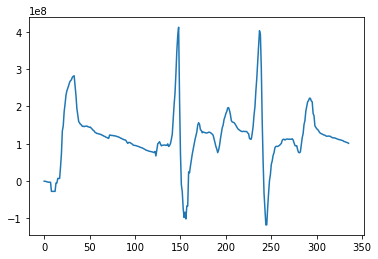

In [270]:
plt.plot(cumsummed_data)

This definitely looks better. The first page is set on page load. Then there is a sharp oscillation for each page turn. The last frame fades to black and should be excluded. 

To find pages this way we could look for "local" mins. Local meaning the smallest value for X nearby frames in each direction. Like before we would need to find a stable point between these mins to be the best candidates for OCR. Further, it looks like negative local mins represent pages.

# Try out the approaches
Both algorithms are pretty similar. To reduce the amount of code we will need we'll create 2 functions. We'll revise the first algorithm to use the local min approach but set to get local mins less than -0.5e8 rather than simply negative ones like in the cumsum. 
Functions:  
1.  Get local mins less than X
1.  Find stable point on line  

With just those 2 things we should have good enough OCR candidate points found automatically!

In [271]:
from scipy import signal

In [273]:
def get_local_mins(series, less_than=0, window_size=20):
    pass
series=cumsummed_data
less_than=proposed_threshold
window_size=20
idxes=signal.argrelextrema(series, np.less, order=window_size)[0]
filtered_idxes=[]
for i in idxes:
    if series[i]<less_than:
        filtered_idxes.append(i)
filtered_idxes

[156, 244]

In [274]:
def get_local_mins(series, less_than=-0.5e8, window_size=20):
    idxes=signal.argrelextrema(series, np.less, order=window_size)[0]
    filtered_idxes=[]
    for i in idxes:
        if series[i]<less_than:
            filtered_idxes.append(i)

    return filtered_idxes
page_turns=[0]+get_local_mins(cumsummed_data)
page_turns

[0, 156, 244]

GOT EM, let's plot them

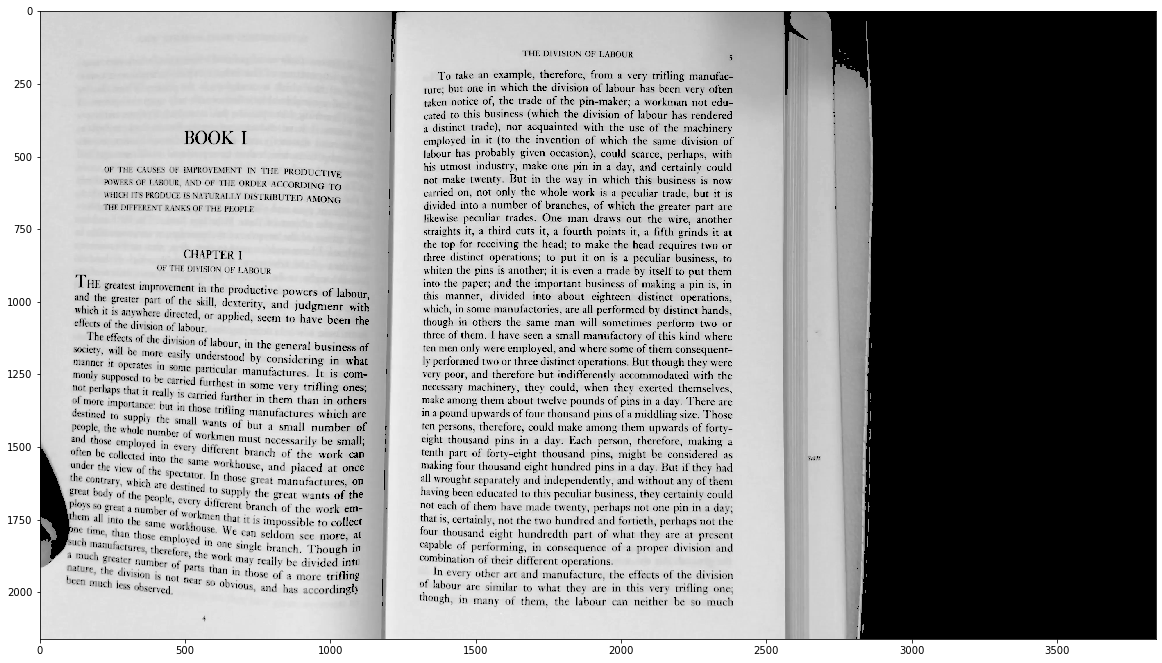

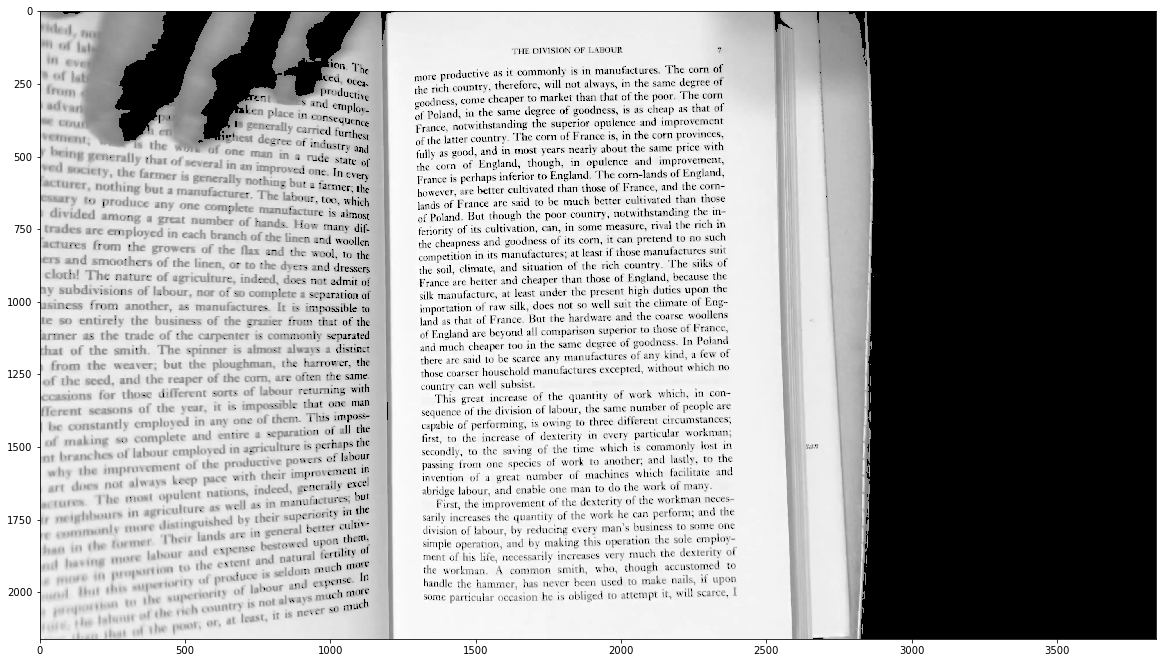

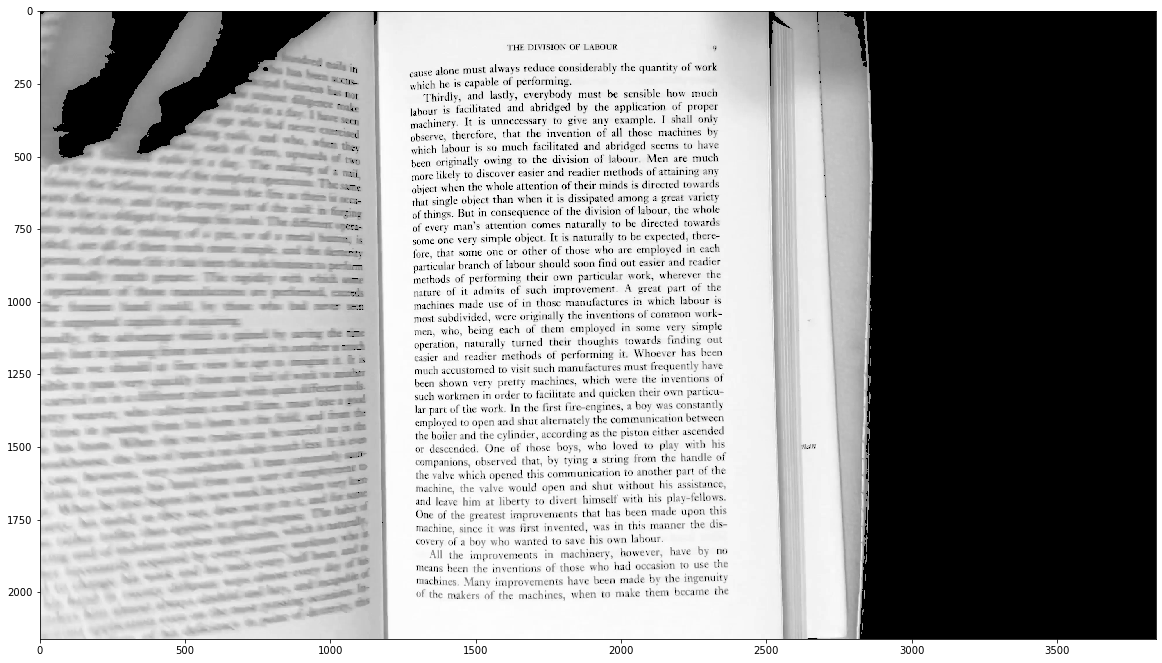

In [275]:
for i in page_turns:
    draw_frame(cleaned_frames[i])

Now let's find stable points. We'll do a rolling sum of K left values, then find the local minima on that series

In [276]:
def get_stable_point(series, window_size=20):
    pass

In [277]:
page_turns

[0, 156, 244]

<AxesSubplot:>

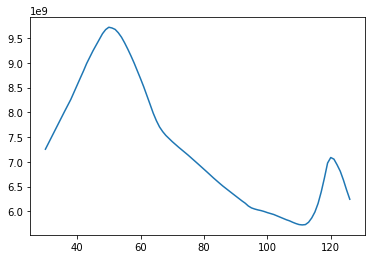

In [278]:
import pandas as pd
page_turn=0
series=cumsummed_data[page_turns[page_turn]:page_turns[page_turn+1]]
series=pd.Series(series)
window_size=60
rolling_sum=series.rolling(window_size,center=True).sum()
rolling_sum.plot()

In [279]:
#60 seems like a reasonable window size. Let's got the smallest min
get_local_mins(rolling_sum.fillna(1e10).values,less_than=1e10,window_size=5)

[30, 111, 126]

In [280]:
np.median([10,50])

30.0

In [281]:
#This isn't terrible but feels like there's some more theory I need to brush  up on. Still let's "roll" with it.
#We'll just take the median of the found local_mins

In [300]:
N_PIXELS=2160*3840

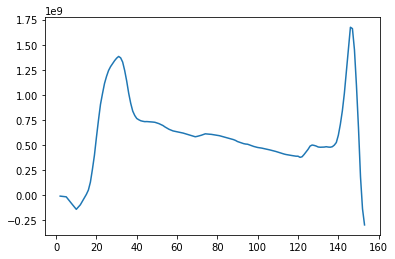

[10, 69, 121, 131, 153]
[-3.399157624421296, 14.05484001253858, 9.188919873649692, 11.546869333526235, -8.965582802854938]
69


NameError: name 'strt_frame' is not defined

In [312]:
#60 seems like a reasonable window size. Let's got the smallest min
import pandas as pd
def get_stable_points(series):
    series=pd.Series(series)
    window_size=5
    rolling_sum=series.rolling(window_size,center=True).sum()
    rolling_sum.plot()
    plt.show()
    mins=get_local_mins(rolling_sum.fillna(1e20).values,less_than=1e20,window_size=5)
    print(mins)
    #mins=[mins[0]]
    sums=[np.sum(series[i])/N_PIXELS for i in mins]
    print(sums)
    ret_val=mins[np.argmax(sums)]
    print(ret_val)
    return mins
series_to_find_stables=[]
for i in range(len(page_turns)):
    if i+1>=len(page_turns):#for last page turn being the end
        upper=len(cumsummed_data)
    else:
        upper=page_turns[i+1]
    series_to_find_stables.append((page_turns[i],cumsummed_data[page_turns[i]:upper]))
frames_to_try=[]
for start_frame,page_series in series_to_find_stables:
    stable_point=get_stable_points(page_series)
    frames_to_try+=[x+strt_frame for x in stable_point]
frames_to_try

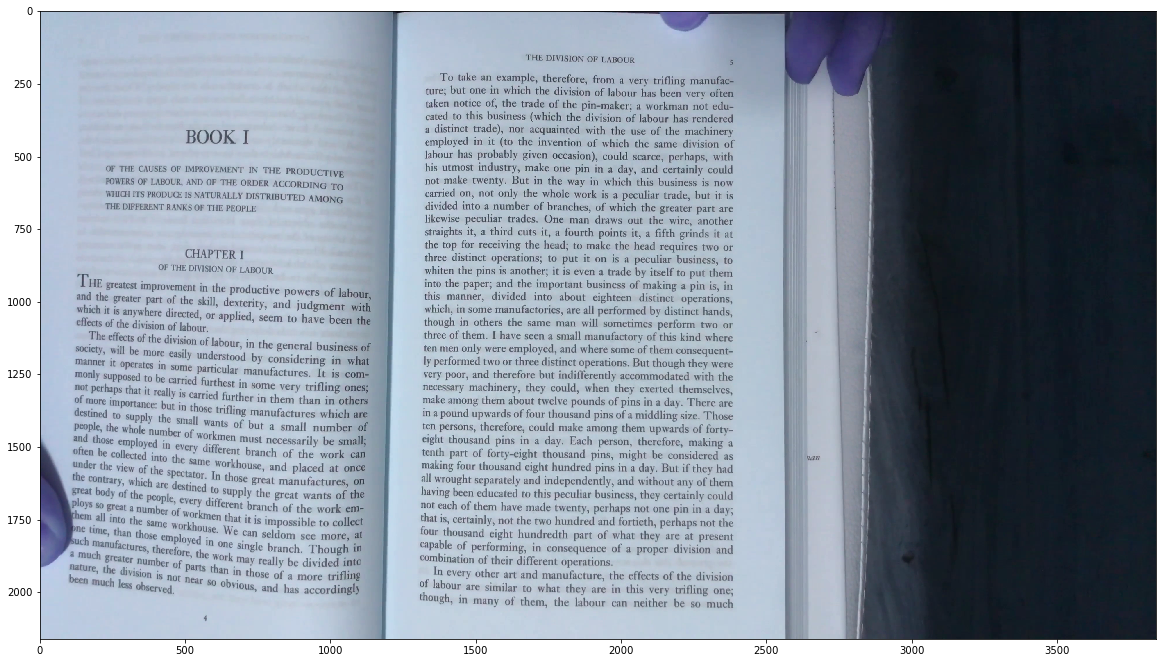

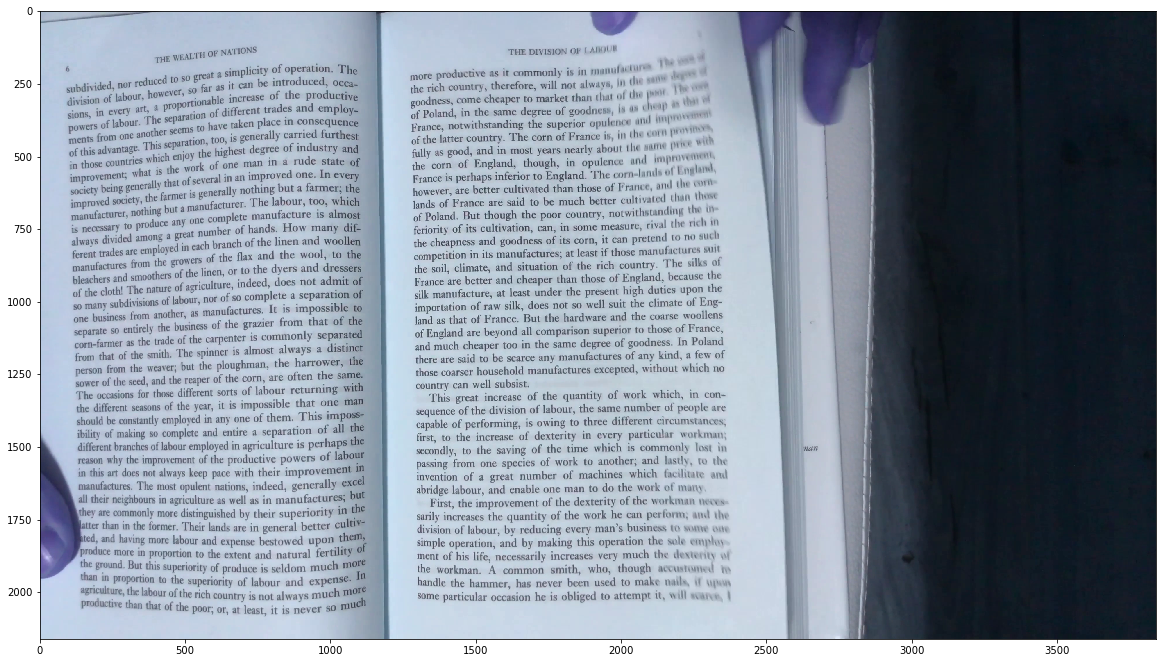

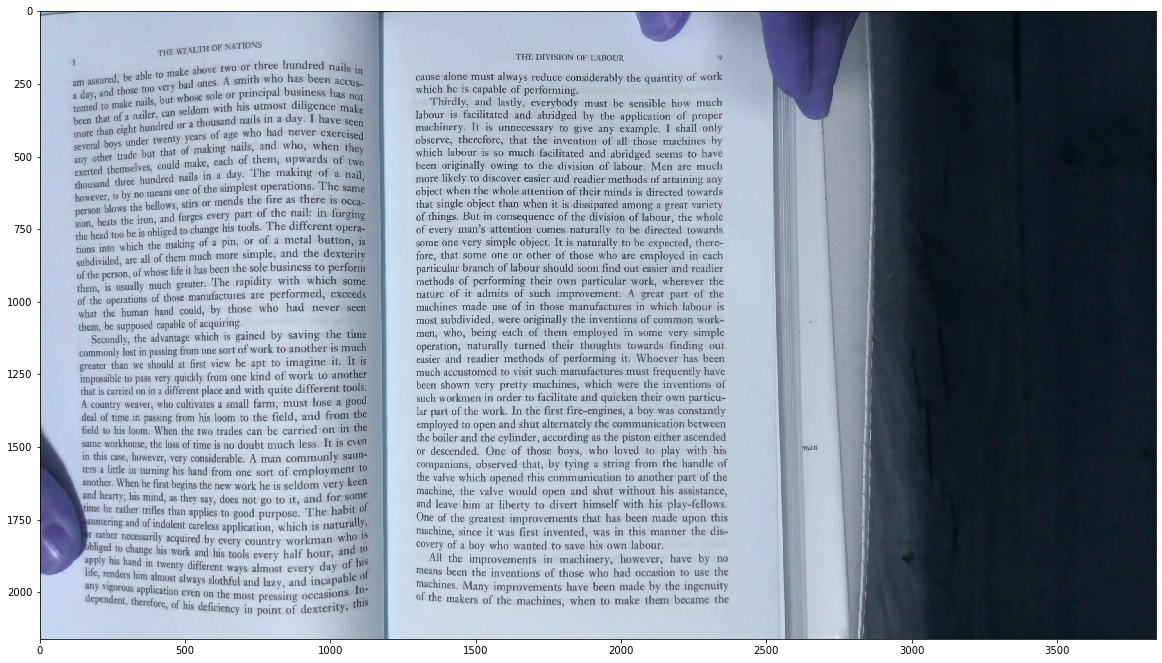

In [310]:
for frame_idx in frames_to_try:
    draw_frame(rotated_frames[frame_idx])